## Setup


In [1]:
! [[ -f data.zip ]] || wget https://www.dropbox.com/s/m1ie2zq8nkburar/data.zip?raw=1 -O data.zip && unzip data.zip

--2020-03-11 17:51:27--  https://www.dropbox.com/s/m1ie2zq8nkburar/data.zip?raw=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/m1ie2zq8nkburar/data.zip [following]
--2020-03-11 17:51:27--  https://www.dropbox.com/s/raw/m1ie2zq8nkburar/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5fcc7b25fa7c41543aacd60ac7.dl.dropboxusercontent.com/cd/0/inline/AzsRJi-LmBm2PKxJAohxUwMzPdSNKycXx-PAtBxeIarfVZ47KNEroLpvUtlW1uxIHoLHvw7LCV1odj12gPZuXxxl24i6LIlJ9J1cxHzipJi1v9lYSKKcaPnDjEy74zpy5sU/file# [following]
--2020-03-11 17:51:28--  https://uc5fcc7b25fa7c41543aacd60ac7.dl.dropboxusercontent.com/cd/0/inline/AzsRJi-LmBm2PKxJAohxUwMzPdSNKycXx-PAtBxeIarfVZ47KNEroLpvUtlW1uxIHoLHvw7LCV1odj12gPZuXxxl24i6LIlJ9J1cxHzipJi1v9lYSKKcaPnD

In [0]:
! [[ -d box-unet ]] || git clone --quiet https://github.com/sdll/box-conv-vis.git && mv box-conv-vis/* .

In [26]:
! pip install -q gsheet-keyring ipython-secrets comet_ml tqdm

     |████████████████████████████████| 184kB 47.9MB/s 
     |████████████████████████████████| 409kB 50.8MB/s 
     |████████████████████████████████| 204kB 60.0MB/s 
     |████████████████████████████████| 2.3MB 40.5MB/s 


In [2]:
! python3 -m pip install -q git+https://github.com/shrubb/box-convolutions.git

## Imports

In [0]:
from comet_ml import Experiment 

import argparse
from pathlib import Path

from box_convolution import BoxConv2d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm as tqdm_base


from pytorch_ssim import ssim

from timeit import default_timer as timer
import cv2

sns.set()


def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, "_instances"):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)

## Environment

In [0]:
DATA_PATH = "data"
GROUND_TRUTH_LABEL = "ground_truth"
NOISY_IMAGES_LABEL = "noisy"
TRAIN_LABEL = "train"
TEST_LABEL = "val"
# TRAIN_POSTFIX = "normed_crops.33.tensor"
TRAIN_POSTFIX = "normalized_data.tensor"
TEST_POSTFIX = "normalized_data.tensor"
TRAIN_GT_DATA = Path(DATA_PATH) / TRAIN_LABEL / GROUND_TRUTH_LABEL / TRAIN_POSTFIX
TRAIN_NOISY_DATA = Path(DATA_PATH) / TRAIN_LABEL / NOISY_IMAGES_LABEL / TRAIN_POSTFIX
TEST_GT_DATA = Path(DATA_PATH) / TEST_LABEL / GROUND_TRUTH_LABEL / TEST_POSTFIX
TEST_NOISY_DATA = Path(DATA_PATH) / TEST_LABEL / NOISY_IMAGES_LABEL / TEST_POSTFIX

# DEVICE = "cuda"
DEVICE = "cpu"

PROJECT = "fastrino"
# COMET_ML_API_KEY = get_secret("comet-{}".format(PROJECT))
COMET_ML_API_KEY = "9z9HNbjFAJyWxKSYUyMw0Yd2s"

NUM_BOX_FILTERS = 40
MAX_INPUT_H = 1024
MAX_INPUT_W = 1024
SCALE_FACTOR = 2
BOX_VIDEO_RESOLUTION = (1200, 1200)
VIDEO_LOG = "box-conv-vis.avi"

In [3]:
experiment = Experiment(
    api_key=COMET_ML_API_KEY,
    project_name=PROJECT,
    workspace=PROJECT,
    auto_output_logging=None,
)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/fastrino/fastrino/9ebb29c07e4f499ba7632a2c1ab0a566



## Model

In [0]:
class Model(nn.Module):
    def __init__(self, in_channels, max_input_h, max_input_w):
        super().__init__()
        self.box_conv = BoxConv2d(in_channels, NUM_BOX_FILTERS, max_input_h, max_input_w)
        self.conv_1x1 = nn.Conv2d(NUM_BOX_FILTERS, NUM_BOX_FILTERS, 1, 1)
        self.net = nn.Sequential(
            self.box_conv,
            self.conv_1x1,
            nn.ReLU(inplace=True),
            nn.MaxPool2d(SCALE_FACTOR),
            nn.Upsample(scale_factor=SCALE_FACTOR, mode="nearest"),
            nn.Conv2d(NUM_BOX_FILTERS, in_channels, 1, 1),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

## Utilities

In [0]:
def get_arg_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument("--max-input-h", type=int, default=MAX_INPUT_H)
    parser.add_argument("--max-input-w", type=int, default=MAX_INPUT_W)
    parser.add_argument("--lr", type=float, default=1e-4)
    parser.add_argument("--batch-size", type=int, default=1)
    parser.add_argument("--num-epochs", type=int, default=1)
    parser.add_argument("--seed", type=int, default=42)

    return parser


def get_criterion():
    return nn.MSELoss()


def get_optimizer(model, lr=0.001):
    return optim.Adam(model.parameters(), lr)


def psnr(prediction, target, max_pixel=255.0):
    return 10.0 * ((max_pixel ** 2) / ((prediction - target) ** 2).mean()).log10()


class PlaneLoader(torch.utils.data.Dataset):
    def __init__(self, gt_data, noisy_data):
        self.gt_data = torch.load(gt_data)
        self.noisy_data = torch.load(noisy_data)

    def __len__(self):
        return len(self.noisy_data)

    def __getitem__(self, index):
        noisy_image = self.noisy_data[index]
        if len(noisy_image.shape) == 2:
            noisy_image = noisy_image[None, :, :]
        gt_image = self.gt_data[index]
        if len(gt_image.shape) == 2:
            gt_image = gt_image[None, :, :]

        noise = noisy_image - gt_image
        return noisy_image, noise


def train(experiment, log=VIDEO_LOG):
    parser = get_arg_parser()
    args = parser.parse_args(args=[])

    if VIDEO_LOG:
        box_video = cv2.VideoWriter(
            log, cv2.VideoWriter_fourcc(*"XVID"), 25, BOX_VIDEO_RESOLUTION
        )

    train_loader = torch.utils.data.DataLoader(
        PlaneLoader(TRAIN_GT_DATA, TRAIN_NOISY_DATA),
        batch_size=args.batch_size,
        shuffle=True,
    )

    image, noise = next(iter(train_loader))

    args.in_channels = 1 if len(image.shape) == 3 else image.shape[1]
    experiment.log_parameters(vars(args))

    model = Model(args.in_channels, args.max_input_h, args.max_input_w).to(DEVICE)

    criterion = get_criterion()
    optimizer = get_optimizer(model, args.lr)

    for epoch in tqdm(range(args.num_epochs), desc="Epoch", unit="epochs"):
        with experiment.train():
            model.train()
            train_psnr = []
            train_ssim = []

            for image, noise in tqdm(train_loader, desc="Train images", unit="images"):
                if log:
                    video_background = torch.nn.functional.pad(
                        image[0], (14, 14, 14, 14)
                    )
                    video_background = torch.nn.functional.interpolate(
                        video_background.unsqueeze(0),
                        size=BOX_VIDEO_RESOLUTION,
                        mode="nearest",
                    )[0, 0]
                    video_background = video_background.unsqueeze(-1).repeat(1, 1, 3)
                    video_background = video_background.mul(255).round().byte().numpy()

                image = image.to(DEVICE)
                noise = noise.to(DEVICE)

                prediction = model(image)
                loss = criterion(prediction, noise)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                current_psnr = psnr(image - prediction, image - noise).data.item()
                current_ssim = ssim(image - prediction, image - noise).data.item()
                train_psnr.append(current_psnr)
                train_ssim.append(current_ssim)
                experiment.log_metric("psnr", current_psnr)
                experiment.log_metric("ssim", current_ssim)
                experiment.log_metric("loss", loss.data.item())

                if log:
                    box_importances = (
                        model.conv_1x1.weight.detach().float().abs().max(0)[0].squeeze()
                    )
                    box_importances /= box_importances.max()
                    boxes_plot = model.box_conv.draw_boxes(
                        resolution=BOX_VIDEO_RESOLUTION, weights=box_importances
                    )
                    box_video.write(
                        cv2.addWeighted(boxes_plot, 1.0, video_background, 0.25, 0.0)
                    )

            experiment.log_metric("mean_psnr", np.mean(train_psnr))
            experiment.log_metric("mean_ssim", np.mean(train_ssim))
    return model


def test(experiment, model):
    test_loader = torch.utils.data.DataLoader(
        PlaneLoader(TEST_GT_DATA, TEST_NOISY_DATA), batch_size=1, shuffle=False
    )
    with experiment.test():
        model.eval()
        test_psnr = []
        test_ssim = []
        test_prediction_times = []
        for image, noise in test_loader:
            image = image.to(DEVICE)
            noise = noise.to(DEVICE)
            start = timer()
            prediction = model(image)
            end = timer()
            prediction_time = end - start
            test_prediction_times.append(prediction_time)
            experiment.log_metric("prediction_time", prediction_time)
            gt_image = image - noise
            current_psnr = psnr(image - prediction, gt_image).data.item()
            current_ssim = ssim(prediction, gt_image).data.item()
            test_psnr.append(current_psnr)
            test_ssim.append(current_ssim)

        test_psnr = np.mean(test_psnr)
        test_ssim = np.mean(test_ssim)
        test_prediction_time = np.mean(test_prediction_times)

        experiment.log_metric("mean_psnr", test_psnr)
        experiment.log_metric("mean_ssim", test_ssim)
        experiment.log_metric("mean_prediction_time", test_prediction_time)

    return test_psnr, test_ssim, test_prediction_time

In [6]:
model  = train(experiment)

Epoch: 100%|██████████| 1/1 [59:22<00:00, 3562.09s/epochs]


In [7]:
test_psnr, test_ssim, test_prediction_time = test(experiment, model)
print(
    "Mean Test PSNR: {}\nMean Test SSIM: {}\nMean Prediction Time: {}".format(
        test_psnr, test_ssim, test_prediction_time
    )
)

Mean Test PSNR: 76.72945074601607
Mean Test SSIM: 0.023219898999245328
Mean Prediction Time: 5.072877594454605


In [0]:
test_loader = torch.utils.data.DataLoader(
    PlaneLoader(TEST_GT_DATA, TEST_NOISY_DATA),
    batch_size=1,
    shuffle=False)


In [0]:
test_it = iter(test_loader)

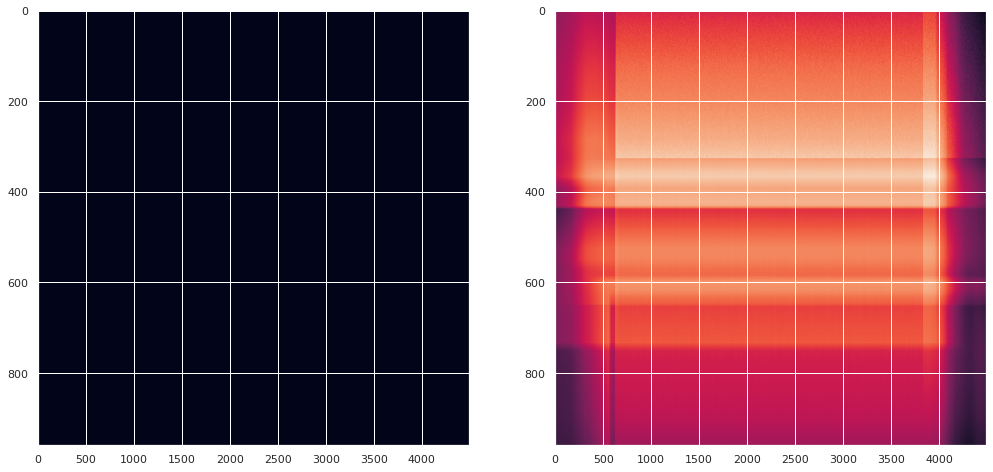

In [14]:
image, noise = next(test_it)
fig = plt.figure(figsize=(17, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow((image - noise).squeeze(), interpolation='nearest', aspect='auto')
ax2.imshow(model(image.to(DEVICE)).data.to("cpu").squeeze(),
           interpolation='nearest', aspect='auto')
plt.show()